### From the earlier Jupyter notebooks, a data set was scraped from open source government data, pre-processed and pickled for use in this body of work. 

### In the notebook, the training data set will be used to create models for the prediction of the "no of rainy days" per month, based on some independent variables listed below. 

The '2_Weather_Proc' data set includes details of ~460 different monthly time periods, recorded at the Change Climate Station. Here are the fields:

| Field          | Description|
|----------------|--------------------------------------------------------|
| Year-month                | Month and Year of Data Point                |
| temp_mean_daily_min       | The monthly and annual mean daily minimum temperature                                                               |
| temp_extremes_min         | The absolute extreme minimum air temperature|
| temp_mean_daily_max       | The monthly and annual mean daily maximum temperature                                                               |
| mean_temp                 | The monthly mean air temperature            |
| max_temperature           | The monthly extreme maximum air temperature |
| mean_sunshine_hrs         | The monthly mean sunshine hours in a day    |
| wet_bulb_temperature      | The hourly wet bulb temperature             |
| maximum_rainfall_in_a_day | The highest daily total rainfall            |
| total_rainfall            | The total monthly rainfall                  |
| rh_extremes_minimum       | The absolute extreme minimum relative humidity                                                                  |
| mean_rh                   | The monthly mean relative humidity          |
| no_of_rainy_days          | The number of rain days (day with rainfall amount of 0.2mm or more)                                                  |

### Import Libraries

In [1]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# For scoring of classifiers
from sklearn.metrics import accuracy_score, jaccard_similarity_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


### Load Data from Pickled Files earlier

In [2]:
# Pickle all the training (post normalization) 
# and testing data sets

X_train = pickle.load(open("X_train", "rb"))
print('Normalized X Training Set: ', X_train[0:5])
print('Shape X Training Set: ', X_train.shape)

X_test = pickle.load(open("X_test", "rb"))
print('Normalized X Testing Set: ', X_test[0:5])
print('Shape X Testing Set: ', X_test.shape)

y_train  = pickle.load(open("y_train", "rb"))
print('Y Training Set: ', y_train[0:5])
print('Shape Y Training Set: ', y_train.shape)

y_test  = pickle.load(open("y_test", "rb"))
print('Y Testing Set: ', y_test[0:5])
print('Shape Y Testing Set: ', y_test.shape)

validate_set  = pickle.load(open("validate_set", "rb"))
print('Validation Set: ', validate_set[0:5])
print('Shape Validation Set: ', validate_set.shape)

Normalized X Training Set:  [[ 0.82023115  0.45825456  0.7862026   0.90725105  0.40359012  2.12790708
   0.81353177 -0.26478353 -0.60225205 -0.14105368 -0.52222186  0.13827682]
 [ 1.04689111 -2.02533493 -1.68336815 -2.27939782 -2.20905301 -1.32436175
   0.27688866  2.65581943  2.45181229  1.31696654  1.02057202 -1.31697516]
 [ 0.14025128 -0.97961304  0.22493652  1.02981447 -0.19019241  0.91961299
  -0.08087342 -0.53659147 -0.51465287 -2.14583148 -1.64964816  0.42932721]
 [ 0.59357119  0.45825456  1.45972189  1.15237788  1.47239867  0.74699955
   0.9924128   2.63716594 -0.0171236  -1.05231632 -0.43321452 -0.44382397]
 [ 0.70690117  0.19682409 -1.23435528 -1.29889048 -0.90273145 -2.18742896
  -0.43863549  0.79047082  2.39227887  0.77020896  1.76229985  1.59352879]]
Shape X Training Set:  (261, 12)
Normalized X Testing Set:  [[-1.91828691  0.62301395 -0.23313979 -0.76075886  0.32148603  1.07103832
  -2.90742372 -1.14094289 -1.25174443 -0.28890769 -2.13227388 -1.27117919]
 [ 0.6916849   0.

#### Function for plotting data - Distribution and Scatter Plot

In [3]:
def DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, plot_type): 
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)

    hist = True
    color1 = "red"
    color2 = "blue"
    color3 = "green"
    lw = 3
    
    if plot_type == 1:
        ax1 = sns.distplot(RedFunction, hist=hist, color=color1, label=RedName,
                           kde_kws={"color": color1, "lw": lw})
        ax2 = sns.distplot(BlueFunction, hist=hist, color=color2, label=BlueName, 
                           ax=ax1, kde_kws={"color": color2, "lw": lw})
    elif plot_type == 2:            
        plt.scatter(RedFunction, BlueFunction, label="Test vs Predicted",
                    s=25, c = color3, zorder=10)
        
        xymax = round(max(RedFunction.max()+5, BlueFunction.max()+5), -1)

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        #plt.axes().set_aspect('equal')
        plt.xlim(0, xymax)
        plt.ylim(0, xymax)  
       
    plt.title(Title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.show()
    plt.close()

#### Function for plotting data - Dual Plot

In [20]:
def max_value(inputlist):
    return max([sublist[-1] for sublist in inputlist])

def min_value(inputlist):
    return min([sublist[-1] for sublist in inputlist])

def dual_plot(xvalue, yvalue, label, color, lw, 
              width, height, Title, xlabel, ylabel):
    plt.figure(figsize=(width, height))

    for i in range(len(yvalue)):
        xmax = round(max(xvalue)+1)
        xmin = round(min(xvalue)-1)
        ymax = round(max_value(yvalue)+1)
        ymin = round(min_value(yvalue)-1)
        plt.plot(xvalue, yvalue[i], label=label[i], 
                 color=color[i], linewidth=lw)
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)       
    plt.title(Title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.show()
    plt.close()    
    return

#### Residual plot the actual vs test values 

In [5]:
def res_plot(RedFunction, BlueFunction, xlabel, ylabel):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    cmap = sns.cubehelix_palette(dark=.9, light=.1, as_cmap=True)
    sns.residplot(RedFunction, BlueFunction, ax=ax, label = "Residual",
                  scatter_kws={"cmap": cmap}, lowess=True, color='r')
    ax.set_title('Residual between Predicted and Test set')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return

6 different Supervised Machine Learning models will be attempted. The first 3 are (what I term for this work) "basic":
1. Multilinear Regression
2. Polynomial Regression
3. Ridge Regression

The more "advanced" models are:
4. K Nearest Neighbours
5. Decision Tree
6. Support Vector Machine

I will also compute 2 Unsupervised models:
7. K-Means
8. DBScan

## 1. Multilinear Regression

In [6]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Train model on training set. Note that data set must be in nparray format
regr = linear_model.LinearRegression()
x_MLR = np.asanyarray(X_train)
y_MLR = np.asanyarray(y_train)
regr.fit(x_MLR, y_MLR)

# Prediction on test set
yhat_MLR = regr.predict(X_test)

# Coefficients
print('Coefficients: ', regr.coef_)
# Intercepts
print('Intercepts: ', regr.intercept_)

# Mean Absolute Error
#a = np.mean(np.absolute(yhat_MLR-y_test))
#print('Mean Absolute Error: {:.2f}'.format(a))
# Residual sum of Squares/ Mean Squared Error (MSE)
#b = np.mean((yhat_MLR-y_test)**2)
#print('Mean Squared Error: {:.2f}'.format(b))
# Variance: 1 is perfect prediction
#c = regr.score(x_MLR, y_MLR)
#print('Variance: {:.2f}'.format(c))
# R2 Error
#d = r2_score(yhat_MLR, y_test)
#print('R2-error: {:.2f}'.format(d))

e = regr.score(X_train, y_train)
print('R2-error of Training Set: {:.3f}'.format(e))
f = regr.score(X_test, y_test)
print('R2-error of Testing Data: {:.3f}'.format(f))

print("Pred values:", yhat_MLR[0:10])
print("True values:", y_test[0:4])

Coefficients:  [-0.56657634 -0.10172895 -0.69121448  1.03376011  0.05245589 -1.66366568
  0.37793364 -1.42960793  2.97515327 -0.47459174  1.26844257  0.3662481 ]
Intercepts:  14.011494252873556
R2-error of Training Set: 0.735
R2-error of Testing Data: 0.643
Pred values: [ 6.41972878 18.50940359 16.24613844 14.06612207 15.21685311 13.47620958
  7.27889033 19.2426345  11.44302751 15.46835584]
True values: [ 6. 22. 18. 15.]


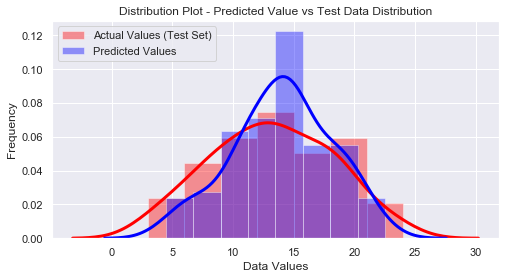

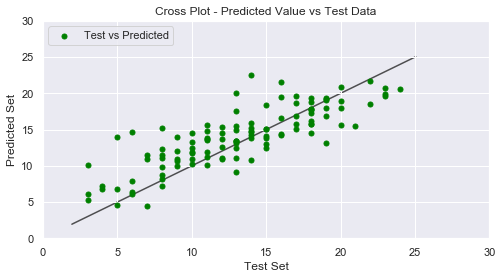

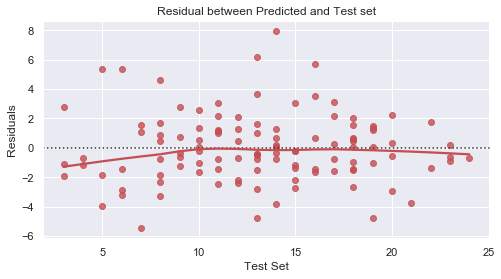

In [7]:
RedFunction = y_test # Test Data Set
BlueFunction = yhat_MLR # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

## 2. Second-Order Polynomial Regression

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# Cast the train nparray format data to new variables
x_train_poly = x_MLR
y_train_poly = y_MLR

x_test_poly = np.asanyarray(X_test)
y_test_poly = np.asanyarray(y_test)

poly = PolynomialFeatures(degree=2)
# Takes the x-values, raises them to degree=n
X_train_poly = poly.fit_transform(x_train_poly)
X_test_poly = poly.fit_transform(x_test_poly)
# Displays the matrix of the powers applied to each number
#print (poly.powers_)

# Polyfit is special case of MLR, therefore use 
# sklearn.linear_model.LinearRegression()
clf = linear_model.LinearRegression()
Y_train_poly = clf.fit(X_train_poly, y_train_poly)

# Coefficients, just the first 3.
print('First 3 Coefficients: ', clf.coef_[:3])
print('Total Number of Coefficients: ', len(clf.coef_))
# Intercepts
print('Intercepts: ', clf.intercept_)

# Prediction
yhat_poly = clf.predict(X_test_poly)

# Mean Absolute Error
#a1 = np.mean(np.absolute(yhat_poly-y_test_poly))
#print('Mean Absolute Error: {:.2f}'.format(a1))
# Residual sum of Squares/ Mean Squared Error (MSE)
#b1 = np.mean((yhat_poly-y_test_poly)**2)
#print('Mean Squared Error: {:.2f}'.format(b1))
# Variance: 1 is perfect prediction
#c1 = regr.score(x_train_poly, y_train_poly)
#print('Variance: {:.2f}'.format(c1))
# R2 Error
#d1 = r2_score(yhat_poly, y_test_poly)
#print('R2-error: {:.2f}'.format(d1))

# Calculate R2 of the training and test data - goodness of fit
e1 = clf.score(X_train_poly, y_train_poly)
print('R2-error of Training Set: {:.3f}'.format(e1))
f1 = clf.score(X_test_poly, y_test_poly)
print('R2-error of Testing Data: {:.3f}'.format(f1))

print("Pred values:", yhat_poly[0:10])
print("True values:", y_test_poly[0:10])

First 3 Coefficients:  [-2.01118145e-14 -5.64051593e-01  4.33293407e-02]
Total Number of Coefficients:  91
Intercepts:  14.889127019960311
R2-error of Training Set: 0.860
R2-error of Testing Data: 0.549
Pred values: [ 2.46358061 21.51418777 16.21718587 15.65432156 17.48767073 13.95456721
  5.23216666 23.1016953   7.72885343 21.40768146]
True values: [ 6. 22. 18. 15. 14. 13.  8. 19.  8. 21.]


#### Plot the actual vs test values 

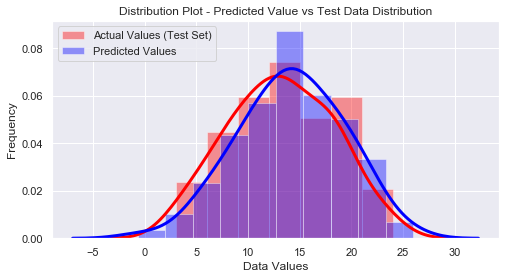

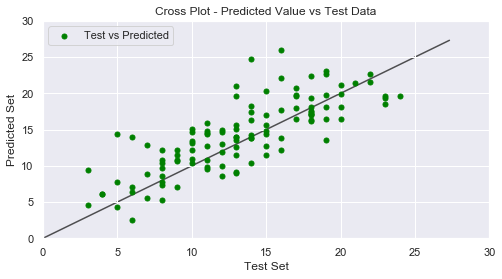

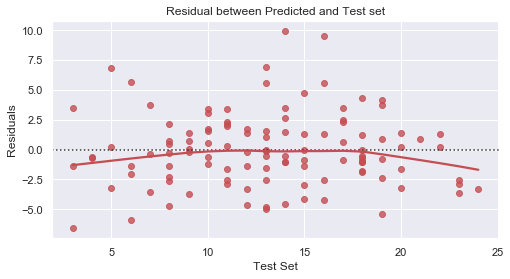

In [9]:
RedFunction = y_test_poly # Test Data Set
BlueFunction = yhat_poly # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

#### Plot the actual vs test values 

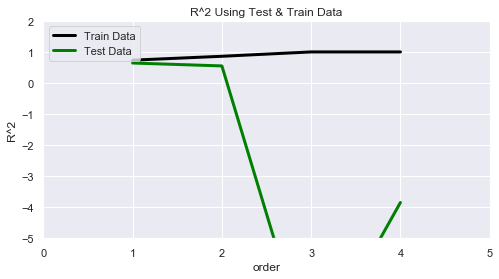

In [21]:
# Is a 2nd order polynomial the best?
Rsqu_test = []
Rsqu_train = []
yvalue = []
label = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train_poly)
    x_test_pr = pr.fit_transform(x_test_poly)
    
    clf.fit(x_train_pr, y_train_poly)
    
    Rsqu_test.append(clf.score(x_test_pr, y_test_poly))
    Rsqu_train.append(clf.score(x_train_pr, y_train_poly))
    
Title = 'R^2 Using Test & Train Data'
xlabel = 'order'
ylabel = 'R^2'
width = 8
height = width/2    
color = ["black", "green", "orange", "red"]
lw = 3

xvalue = order
yvalue.append(Rsqu_train) # Train Data Set
label.append("Train Data" )
yvalue.append(Rsqu_test) # Test Data Set
label.append("Test Data")
dual_plot(xvalue, yvalue, label, color, lw, 
          width, height, Title, xlabel, ylabel)

## 3. Ridge Regression

This data set may suffer from multicolliniarity. To address this, I will model the data to a ridge regression. The alpha term is important for the ridge regression, but since we dont know what a good value to use is,
I will use Gridsearch to find the best value for this hyperparameter.

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

pr=PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train_poly)
x_test_pr = pr.fit_transform(x_test_poly)

alpha_param = [{'alpha': [(10**x) for x in range(-4, 7)]}]
RM = Ridge()
Grid1 = GridSearchCV(RM, alpha_param, cv = 4)

Grid1.fit(x_train_pr, y_train_poly)
BestRR=Grid1.best_estimator_
print("Best Estimator for alpha: ", BestRR)

# Coefficients, just the first 3.
print('First 3 Coefficients: ', BestRR.coef_[:3])
print('Total Number of Coefficients: ', len(BestRR.coef_))
# Intercepts
print('Intercepts: ', BestRR.intercept_)

# Prediction
yhat_poly = BestRR.predict(x_test_pr)

# Calculate R2 of the training and test data - goodness of fit
e2 = BestRR.score(X_train_poly, y_train_poly)
print('R2-error of Training Set: {:.3f}'.format(e2))
f2 = BestRR.score(x_test_pr, y_test_poly)
print('R2-error of Testing Data: {:.3f}'.format(f2))

print("Pred values:", yhat_poly[0:10])
print("True values:", y_test_poly[0:10])

Best Estimator for alpha:  Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
First 3 Coefficients:  [ 0.         -0.64629475  0.07984868]
Total Number of Coefficients:  91
Intercepts:  14.897816696746412
R2-error of Training Set: 0.840
R2-error of Testing Data: 0.658
Pred values: [ 3.17108284 19.12321901 16.8170371  15.26953229 17.0444549  13.58083012
  6.67908726 21.11840474  9.74057533 19.02893666]
True values: [ 6. 22. 18. 15. 14. 13.  8. 19.  8. 21.]


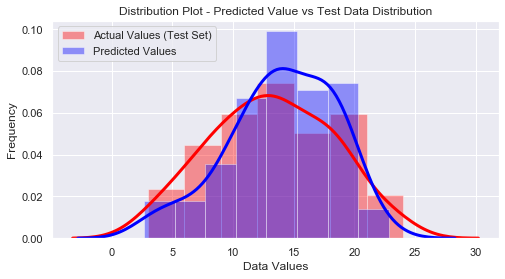

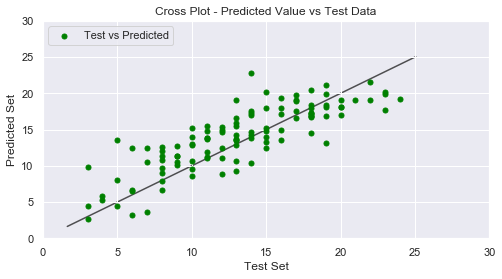

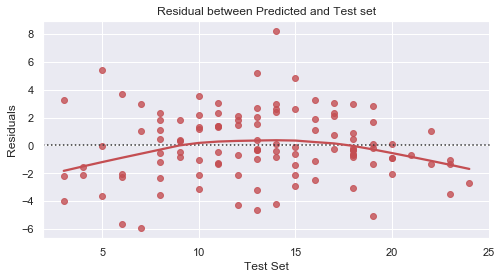

In [12]:
RedFunction = y_test_poly # Test Data Set
BlueFunction = yhat_poly # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

Based on the R2 values, we observe that, with respect to the testing dataset:

1. The Ridge regression shows a good fit, with an R2 of 0.67. Most points lie in the frequency dsitribution of the test set, although there are some points that are overestimate or underestimated at the extremes.

2. The Multilinear regression shows a reasonable fit as well; the R2 value is 0.68. THe frequency distribution, however, shows greater number of poitns in the central region around the mean, and does not capture the tails of the dsitribution quite as well. 

3. The Polynomial regression is not a good fit to this data set; it can be argued that it overfits the data with a 2:1 ratio between the R2 of the training set (0.87) vs the testing set (0.46). Additionally, the mean is displaced between the predicted values and the test values, with a systematic underestimation of the data

#### Pickle the "Basic" Models as a Checkpoint

In [13]:
# Pickle multi-linear regression model
with open('model_regr', 'wb') as file:
    pickle.dump(regr, file)
    
# Pickle polynomial regression model
with open('model_clf', 'wb') as file:
    pickle.dump(clf, file)
    
# Pickle Ridge regression model
with open('model_BestRR', 'wb') as file:
    pickle.dump(BestRR, file)

## 4. K Nearest Neighbours (KNN)

#### The implementation of this algorithm is complicated only by the fact that I dont know what k is the best to use. I will determine this using a loop with a few values, and look at the accuracy plot.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

K = 10
mean_acc = np.zeros((K-1))
jac_sim_score = np.zeros((K-1))
fscore = np.zeros((K-1))
conf_mat = np.zeros((K-1))

std_acc = np.zeros((K-1))
Confusemat = []

In [15]:
for i in range(1,K):
    # Train the model
    neigh = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    yhat_KNN = neigh.predict(X_test)
    
    mean_acc[i-1] = accuracy_score(y_test, yhat_KNN)
    jac_sim_score[i-1] = jaccard_similarity_score(y_test, yhat_KNN)
    #conf_mat[i-1] = confusion_matrix(y_test, yhat, labels=['no_of_rainy_days'])
    fscore[i-1] = f1_score(y_test, yhat_KNN, average='weighted')
    
    # np.std(yhat == y_test):
    # A comparison of two numpy arrays returns a boolean array. 
    # Booleans values are converted into 1(True) and 0 (false) intrinsically
    # / np.sqrt(yhat.shape[0])
    # taking the std of boolean array & dividing that by the 
    # square root length of that array.
    std_acc[i-1] = np.std(yhat_KNN == y_test)/np.sqrt(yhat_KNN.shape[0])

print('Mean Accuracy:', mean_acc)
print('\n')
print('Jaccard Similarity Score:', jac_sim_score)
print('\n')
print('F1 Score:', fscore)
print('\n')
#print('Log Loss:', lloss)
print('F1 Score:\n',classification_report(y_test, yhat_KNN))

Mean Accuracy: [0.10714286 0.13392857 0.10714286 0.10714286 0.14285714 0.20535714
 0.17857143 0.14285714 0.11607143]


Jaccard Similarity Score: [0.10714286 0.13392857 0.10714286 0.10714286 0.14285714 0.20535714
 0.17857143 0.14285714 0.11607143]


F1 Score: [0.10284093 0.12844008 0.1012967  0.10058357 0.13514893 0.20214949
 0.16740611 0.12918986 0.1029322 ]


F1 Score:
               precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         3
         6.0       0.00      0.00      0.00         4
         7.0       0.33      0.33      0.33         3
         8.0       0.40      0.25      0.31         8
         9.0       0.00      0.00      0.00         5
        10.0       0.27      0.43      0.33         7
        11.0       0.06      0.12      0.08         8
        12.0       0.00      0.

C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\quant\Anaconda3\lib\site-pac

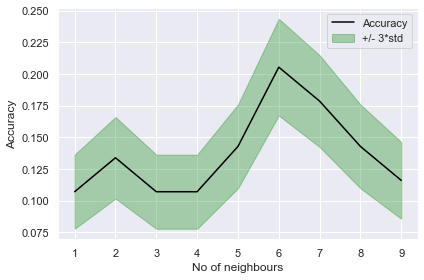

In [16]:
plt.plot(range(1,K), mean_acc, 'black')
plt.fill_between(range(1,K), 
                 mean_acc - 1*std_acc, 
                 mean_acc + 1*std_acc,
                 alpha = 0.3,
                 color = 'green')
plt.legend(('Accuracy', '+/- 3*std'))
plt.ylabel('Accuracy')
plt.xlabel('No of neighbours')
plt.tight_layout()
plt.show()

Ideal number of k is 6 for max accuracy, but max accuracy here is very low. It does even worse than the linear regression model.

In [17]:
neigh = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train)
yhat_KNN = neigh.predict(X_test)

mean_acc_KNN = accuracy_score(y_test, yhat_KNN)
jac_sim_score_KNN = jaccard_similarity_score(y_test, yhat_KNN)
#conf_mat_KNN = confusion_matrix(y_test, yhat, labels=['PAIDOFF'])
fscore_KNN = f1_score(y_test, yhat_KNN, average='weighted')

print('Mean Accuracy:', mean_acc_KNN)
print('\n')
print('Jaccard Similarity Score:', jac_sim_score_KNN)
print('\n')
print('F1 Score:', fscore_KNN)
print('\n')
print('F1 Score:\n',classification_report(y_test, yhat_KNN))

print("Pred values:", yhat_KNN[0:10])
print("True values:", y_test[0:10])

Mean Accuracy: 0.20535714285714285


Jaccard Similarity Score: 0.20535714285714285


F1 Score: 0.20214949252012016


F1 Score:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         3
         6.0       0.00      0.00      0.00         4
         7.0       0.25      0.33      0.29         3
         8.0       0.50      0.25      0.33         8
         9.0       0.20      0.20      0.20         5
        10.0       0.33      0.57      0.42         7
        11.0       0.00      0.00      0.00         8
        12.0       0.22      0.33      0.27         6
        13.0       0.32      0.55      0.40        11
        14.0       0.00      0.00      0.00         8
        15.0       0.67      0.29      0.40         7
       

C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I was really suprised to see the KNN having such a low accuracy score. If you refer to the classification_report table above, I have tablulated if the predicictions are right or wrong based on wheter they are:

1. TN / True Negative: when a case was negative and predicted negative
2. TP / True Positive: when a case was positive and predicted positive
3. FN / False Negative: when a case was positive but predicted negative
4. FP / False Positive: when a case was negative but predicted positive

Precision = TP/(TP + FP) 
Recall = TP/(TP + FN)
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

A cross-plot should be better at putting things in persepctive.

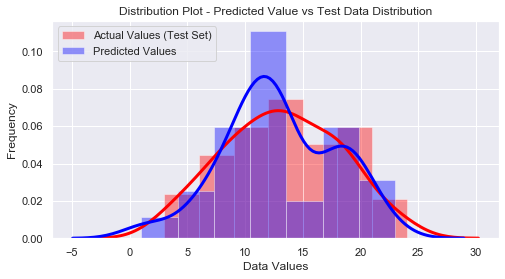

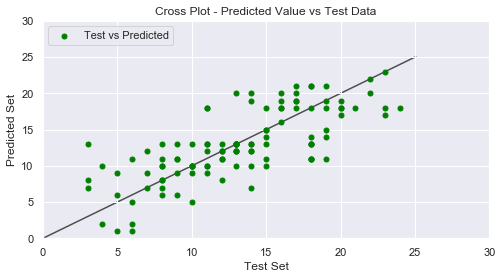

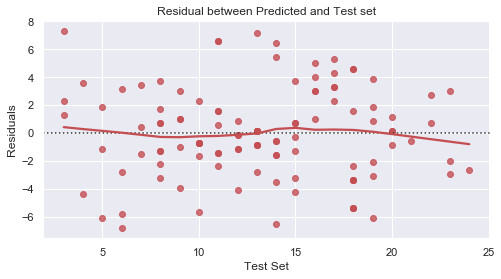

In [18]:
RedFunction = y_test # Test Data Set
BlueFunction = yhat_KNN # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

Interestingly, the frequency distribuion is bimodal. This is clearly incorrect. The redisual plot is evenly spaced around the 0 line, but this is misleading as the scatter about the 0-line is enormous

In [19]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 3.3564822673797607 seconds
